# 主題：政治新聞資料分析
- 組員：王冠人、萬俊彥、廖品琪
- 時間：2019/01/29

## 研究目標
考量臺灣社會政治冷感的現狀，提供一個較為客觀的資料統整，藉由日常生活中的事件觀察政治人物的網路聲量變化，作為一種參與政治的方式。

## 研究方法
1. 爬蟲搜尋網路新聞
2. 進行資料清理及資料分析
4. 視覺化呈現研究結果

## 研究內容及結果

# Part I 爬蟲

- [新頭殼新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/new_talk_crawler.ipynb)
- [自由時報新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/liberty_times_crawler.ipynb)

#  Part II 資料清洗及分析

In [1]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter
from gensim.models import word2vec

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *

path = os.getcwd()
font_path = '../tools/msjh.ttc'
font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

C:\Users\Evan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 載入新聞資料 1. 新頭殼 2. 自由時報 

In [75]:
with open('../crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
with open('../crawler/data/liberty_times.pkl', 'rb') as f:
    data2 = pickle.load(f)

In [76]:
for i in range(len(data2)):
    data.append(data2[i])
len(data)

In [88]:
newData = sorted(data, key=lambda k: dt.strptime(k['date'], "%Y-%m-%d")) 
newData[::1]
contents = [news['content'] for news in newData] 


In [89]:
len(contents) # total 12139 news

12139

### 使用 coshow 找出新詞 -> 自定義辭典

In [90]:
get_coshow(contents[:1000])[:10]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Evan\AppData\Local\Temp\jieba.cache
Loading model cost 0.710 seconds.
Prefix dict has been built succesfully.


[('68', 938),
 ('民進黨', 611),
 ('蔡英文', 474),
 ('對於', 465),
 ('柯文哲', 441),
 ('台北市長', 358),
 ('長參選人', 319),
 ('沒有', 293),
 ('新北市長', 256),
 ('他的', 246)]

### 設定繁體中文斷詞、載入自訂辭典、stopwords

In [91]:
jieba.set_dictionary('../jieba_data/dict.txt.big')
jieba.load_userdict('../jieba_data/userdict.txt')  
stopwords = []
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

Building prefix dict from C:\Users\Evan\Documents\GitHub\HW0_Political_News_Analysis\jieba_data\dict.txt.big ...
Loading model from cache C:\Users\Evan\AppData\Local\Temp\jieba.uf00a95af7eb7bd688f20c5e870249ba2.cache
Loading model cost 1.173 seconds.
Prefix dict has been built succesfully.


In [92]:
# add cutted dict to each news
for i in range(len(newData)):
    current_content = newData[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    newData[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

In [93]:
def remove_stopwords_from_list(word_list, stopwords):
    for word in word_list:
        if word in stopwords:
            word_list.remove(word)
    return word_list

# word2vec 尋找最相似關鍵字

In [94]:
corpus = []
for i in range(len(newData)):
    current_content = newData[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    clean_cutted = remove_stopwords_from_list(current_cutted, stopwords)
    corpus.append(clean_cutted)

In [95]:
corpus[0]

['新北市長朱立倫',
 '今',
 '7',
 '日',
 '57',
 '歲',
 '生日',
 '市',
 '會議',
 '接受',
 '總質詢',
 '時',
 '國民黨議員',
 '蔡淑君',
 '找齊',
 '林口',
 '區',
 '17',
 '位',
 '里長',
 '不',
 '分',
 '藍綠',
 '拍攝',
 '各里',
 '內',
 '建設',
 '影片',
 '齊聲',
 '朱立倫',
 '政績',
 '背書',
 '喊',
 '讚',
 '加上',
 '前行政院長',
 '唐飛',
 '香港',
 '演員',
 '兼',
 '導演',
 '馮淬帆',
 '網紅',
 '館長',
 '陳',
 '之漢',
 '位',
 '林口',
 '居民',
 '提',
 '建言',
 '經常',
 '唇槍',
 '舌戰',
 '議場',
 '氣氛',
 '難得',
 '溫馨',
 '壽星',
 '朱立倫',
 '允諾',
 '中央',
 '協商',
 '林口',
 '交流',
 '道',
 '壅塞',
 '解決辦法',
 '新北市議會',
 '市政',
 '總質詢',
 '今天下午',
 '國民黨',
 '團白珮茹',
 '蔡淑君',
 '洪佳君',
 '王',
 '建章',
 '劉哲彰',
 '邱烽堯',
 '廖正良',
 '周勝考',
 '林金結',
 '議員',
 '質詢',
 '蔡淑君',
 '播放',
 '一支',
 '她',
 '化身',
 '記者',
 '淑君',
 '阿姨',
 '影片',
 '內容',
 '逐一',
 '採訪',
 '林口',
 '區',
 '17',
 '位',
 '跨',
 '黨派',
 '里長',
 '各自',
 '細數',
 '升格',
 '後',
 '市府',
 '在',
 '里',
 '內',
 '施政',
 '建設',
 '進步',
 '最後',
 '不',
 '分',
 '藍綠',
 '齊聲',
 '大喊',
 '朱立',
 '倫',
 '讚',
 '給足',
 '任期',
 '剩',
 '半年',
 '朱立倫',
 '面子',
 '前行政院長',
 '唐飛',
 '演員',
 '兼',
 '導演',
 '馮淬帆',
 '接受',
 '採訪',
 '暢談',
 '居住',
 '林口',
 '良好',

In [96]:
def word_2_vec(corpus):
    model = word2vec.Word2Vec(corpus, size=240, min_count=1, negative=10)
    model_path = os.path.join(path, 'model', 'word2vec.model')
    print ('saving model to {}...'.format(model_path))
    model.save(model_path)

In [97]:
word_2_vec(corpus)

saving model to C:\Users\Evan\Documents\GitHub\HW0_Political_News_Analysis\final_demo\model\word2vec.model...


In [98]:
w2v_model = word2vec.Word2Vec.load(os.path.join(path, 'model', "word2vec.model"))

In [99]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [101]:
most_similar(w2v_model, ['蔡英文', '韓國瑜', '姚文智', '柯文哲', '高嘉瑜', '陳其邁'], 5)

,蔡英文,cos,韓國瑜,cos,姚文智,cos,柯文哲,cos,高嘉瑜,cos,陳其邁,cos
0,蔡英文總統,0.859681,陳其邁,0.753199,丁守中,0.855949,柯,0.879827,王世堅,0.870937,韓國瑜,0.753199
1,總統蔡英文,0.819075,韓,0.701324,柯文哲,0.827705,姚文智,0.827705,柯媽,0.858517,高雄,0.677747
2,蔡總統,0.817438,高雄,0.601629,姚,0.764199,台北市長柯文哲,0.815488,陳佩琪,0.855643,黃偉哲,0.622632
3,總統,0.728597,韓國瑜當選,0.578780,丁,0.754037,丁守中,0.787616,柯粉,0.834956,韓國瑜當選,0.614835
4,賴清德,0.705665,高雄市長韓國瑜,0.571726,柯,0.721107,姚,0.710413,姚,0.830896,韓市長,0.612783


# 試著找出可能人名與事件

In [13]:
cutted_dict = get_cutted_dict(contents)

In [14]:
# 可能人名
# word _len: at least how long
# to: at most how long
possible_name = first_n_words(cutted_dict, 1000, word_len = 3, to =  3)
possible_name[:10]

[('民進黨', 8922),
 ('國民黨', 8420),
 ('柯文哲', 8153),
 ('韓國瑜', 6590),
 ('陳其邁', 4683),
 ('蔡英文', 3738),
 ('蘇貞昌', 3280),
 ('姚文智', 2973),
 ('候選人', 2946),
 ('侯友宜', 2665)]

In [15]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200,  word_len = 4)
possible_events[:10]

[('台北市長柯文哲', 1590),
 ('總統蔡英文', 1356),
 ('時代力量', 1135),
 ('九二共識', 1022),
 ('行政院長賴清德', 1003),
 ('中華民國', 852),
 ('競選總部', 779),
 ('蔡英文總統', 762),
 ('競選辦公室', 720),
 ('兩岸關係', 708)]

### 載入人名、事件

In [16]:
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [17]:
print(' '.join(names[:5]))
print(' '.join(events[:5]))

柯文哲 韓國瑜 陳其邁 蔡英文 蘇貞昌
九二共識 兩岸關係 轉型正義 立委補選 九合一選舉


### 文字雲

47782


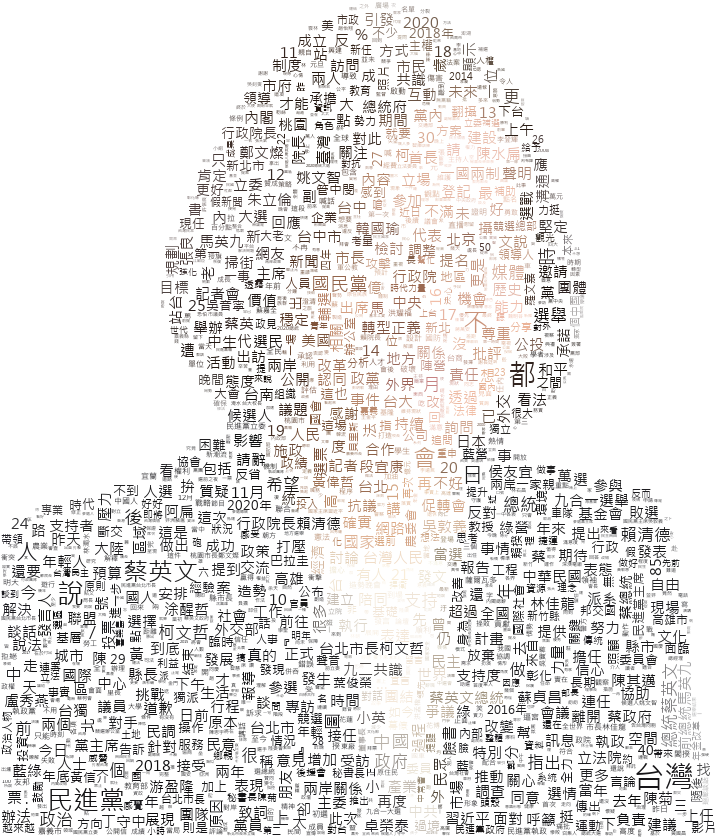

In [15]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()
# plt.imshow(ten_wc, interpolation="bilinear")
# plt.axis("off")
# plt.figure()

In [58]:
'''The most high frequency words that show simultaneously with "蔡英文" '''
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 5)

[('台灣', 5039), ('民進黨', 3893), ('蔡英文', 3738), ('中國', 2136), ('國民黨', 2021)]

42597


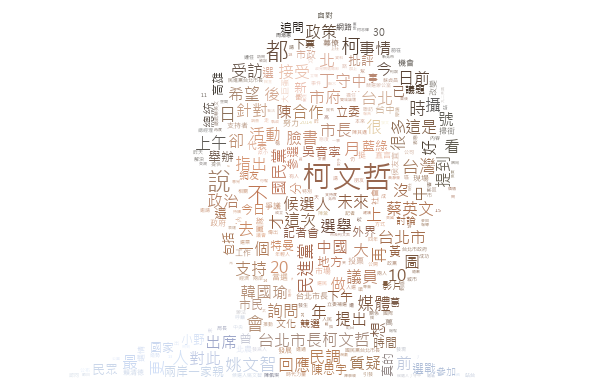

In [60]:
# 柯文哲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [61]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 5)

[('柯文哲', 8153), ('媒體', 2356), ('姚文智', 2120), ('台灣', 2117), ('民進黨', 2107)]

### get date

In [130]:
date_list = [news['date'] for news in newData]
#from old to new
all_date = sorted(list(set(date_list))) 

#delete the year and asc, from new to old
aall_date = [date[5:] for date in all_date][::-1] 
dall_date = aall_date[::-1]

#find the frist index of specific day
date_index = [date_list.index(each_date) for each_date in all_date] #find the frist index of specific day
date_index.append(len(date_list)-1)

#how many news in each day
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)] 
#how many terms in each day
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [103]:
number_of_news[:10] #everyday news

[8, 18, 15, 19, 36, 28, 44, 36, 26, 15]

In [104]:
number_of_terms[:10] #everyday terms

[1865, 5306, 3826, 5764, 10007, 7415, 10210, 8792, 6417, 4602]

In [105]:
# 每日詞數
wn_by_day = {}

# 每日詞頻 
# ratio
tf_by_day = {}

# 每天出現的字
occur_by_day = {}

# 每天出現字的idf 
idf_by_day = {}

for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    #wm
    current_word_dict = merge_one_day_news_dict(oneday_dict)
    wn_by_day[all_date[i]] = current_word_dict
    #tf
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
    tf_by_day[all_date[i]] = current_word_dict
    #occur
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i]) 
    occur_by_day[all_date[i]] = current_word_dict    
    #idf
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i], inverse = True) 
    idf_by_day[all_date[i]] = current_word_dict    

In [109]:
wn_by_day['2018-06-07']['柯文哲']

13.0

In [110]:
tf_by_day['2018-06-07']['柯文哲']

0.0069705093833780166

In [111]:
occur_by_day['2018-06-07']['柯文哲']

0.25

In [112]:
idf_by_day['2018-06-07']['柯文哲']

1.3862943611198906

In [113]:
df_wn = pd.DataFrame(wn_by_day)
df_wn = df_wn.fillna(0)

df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

df_idf = pd.DataFrame(idf_by_day)
df_idf = df_idf.fillna(0)

In [140]:
print(len(aall_date))
dall_date[147:]

230


['11-01',
 '11-02',
 '11-03',
 '11-04',
 '11-05',
 '11-06',
 '11-07',
 '11-08',
 '11-09',
 '11-10',
 '11-11',
 '11-12',
 '11-13',
 '11-14',
 '11-15',
 '11-16',
 '11-17',
 '11-18',
 '11-19',
 '11-20',
 '11-21',
 '11-22',
 '11-23',
 '11-24',
 '11-25',
 '11-26',
 '11-27',
 '11-28',
 '11-29',
 '11-30',
 '12-01',
 '12-02',
 '12-03',
 '12-04',
 '12-05',
 '12-06',
 '12-07',
 '12-08',
 '12-09',
 '12-10',
 '12-11',
 '12-12',
 '12-13',
 '12-14',
 '12-15',
 '12-16',
 '12-17',
 '12-18',
 '12-19',
 '12-20',
 '12-21',
 '12-22',
 '12-23',
 '12-24',
 '12-25',
 '12-26',
 '12-27',
 '12-28',
 '12-29',
 '12-30',
 '12-31',
 '01-01',
 '01-02',
 '01-03',
 '01-04',
 '01-05',
 '01-06',
 '01-07',
 '01-08',
 '01-09',
 '01-10',
 '01-11',
 '01-12',
 '01-13',
 '01-14',
 '01-15',
 '01-16',
 '01-17',
 '01-18',
 '01-19',
 '01-20',
 '01-21',
 '01-22']

### 畫圖

C:\Users\Evan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


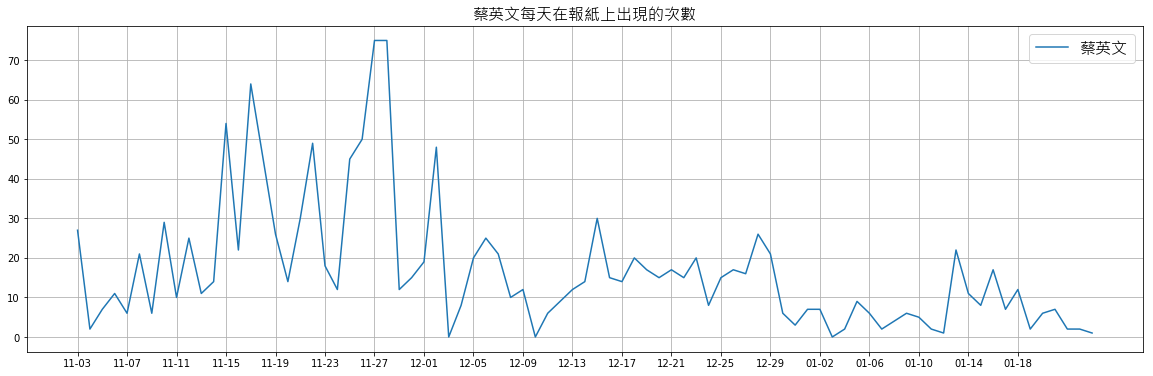

In [141]:
# word times
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.title("蔡英文每天在報紙上出現的次數", fontproperties=font)
plt.plot(all_date[147:], df_wn.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.grid()
plt.show()

C:\Users\Evan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


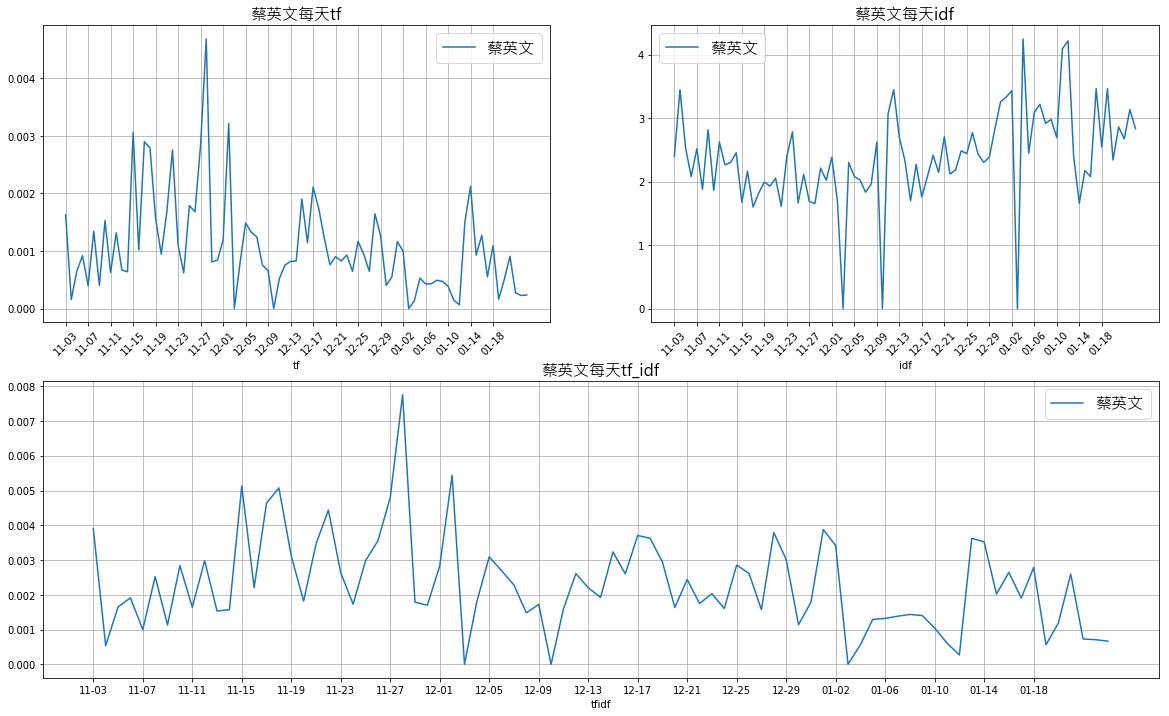

In [144]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='../msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(221)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.title("蔡英文每天tf", fontproperties=font)
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)], rotation=45)
plt.legend(prop=font)
plt.grid()
plt.xlabel('tf')

plt.subplot(222)
plt.plot(aall_date[147:], df_idf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.title("蔡英文每天idf", fontproperties=font)
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)], rotation=45)
plt.legend(prop=font)
plt.grid()
plt.xlabel('idf')

plt.subplot(212)
plt.plot(aall_date[147:], df_idf.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.title("蔡英文每天tf_idf", fontproperties=font)
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.grid()
plt.xlabel('tfidf')

plt.show()

# Correct an obivious bug

In [145]:
def plot_tfdf_of_word(word, df_tf, df_occur, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df_tf.columns.get_loc(date_from)
    to_index = df_tf.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25 #the gap is 25 day
    font = font_manager.FontProperties(fname='../msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    dall_date = aall_date[::-1] #desc
    plt.plot(dall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_idf.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [dall_date[from_index:to_index][i] for i in range(0, date_length, date_int)], rotation=45)

C:\Users\Evan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


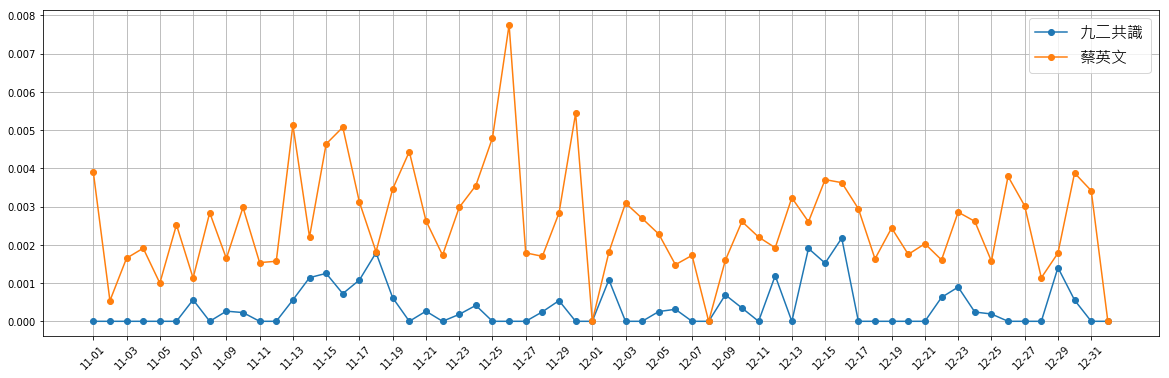

In [146]:
plt.figure(figsize=(20,6))

plot_tfdf_of_word('九二共識', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('蔡英文', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

### 大事件被討論的時間區段與聲量

In [114]:
def get_high_tfdf_date(word, df_tf, df_occur):
    tfdf = get_tfdf(word, df_tf, df_occur) #return the tfdf of this word
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf] #return only high frequency
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))} 
    return tfdf_date

def draw_event(event, i, df_tf, df_occur):
    event_date = get_high_tfdf_date(event, df_tf, df_occur)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])

In [115]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e, df_tf, df_occur) for e in events}
event_high_tfdf_dict['九合一選舉']

{'2018-11-24': 0.0007615105975332301,
 '2018-11-25': 0.0002695716981431267,
 '2018-11-26': 0.0006444655990160315,
 '2018-11-27': 0.00025548759143220696,
 '2018-11-28': 0.0002840320719547916,
 '2018-11-29': 0.0002068233524019918,
 '2018-11-30': 0.00045252281469190716,
 '2018-12-03': 0.0002985498044566326,
 '2018-12-04': 0.0002660853724683512,
 '2018-12-06': 0.0002529358626919602,
 '2018-12-07': 0.0004278074866310161,
 '2018-12-08': 0.00018009451360073768,
 '2018-12-16': 0.00020870246694834399,
 '2019-01-11': 0.00013327592216686143}

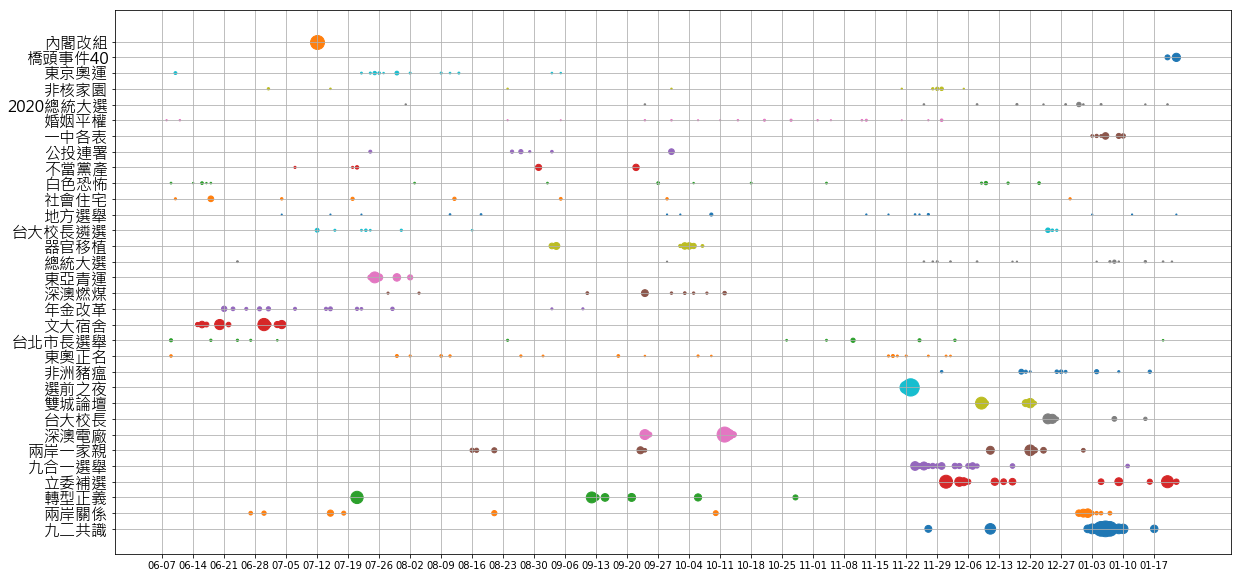

In [118]:
plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i, df_tf, df_occur)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [dall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [30]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
# with open('../data/event_people_dict.json', 'w', encoding='utf-8') as j:
#     json.dump(event_people_dict, j)

In [31]:
pd.DataFrame(event_people_dict).T.head(3)

,丁允恭,丁守中,任美鈴,何孟樺,何志偉,何瑞英,余登發,侯友宜,劉世芳,劉奕霆,...,高思博,高育仁,魏明谷,黃信介,黃偉哲,黃國昌,黃士修,黃敏惠,黃瀞瑩,黃韋鈞
九二共識,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
兩岸關係,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
轉型正義,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,NaN


In [32]:
people_tfdf_dict = {name: list(get_tfdf(name, df_tf, df_occur)) for name in names}

In [33]:
pd.DataFrame(people_tfdf_dict, index=aall_date).T.head(4)

,01-22,01-21,01-20,01-19,01-18,01-17,01-16,01-15,01-14,01-13,...,06-16,06-15,06-14,06-13,06-12,06-11,06-10,06-09,06-08,06-07
柯文哲,0.000135,0.000220,0.000546,0.000000,0.000286,0.000006,0.000234,0.000732,0.000221,0.000109,...,0.000117,0.000233,0.000123,0.000265,0.000259,0.001432,0.001921,0.002752,0.002131,0.001046
韓國瑜,0.000203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000111,0.000706,0.000000,0.000000,...,0.000631,0.000056,0.000043,0.000002,0.001641,0.000389,0.002984,0.006289,0.000092,0.000197
陳其邁,0.000000,0.000118,0.000273,0.000047,0.000000,0.000000,0.000015,0.000029,0.000045,0.000000,...,0.000105,0.000196,0.000078,0.000060,0.000020,0.000017,0.000000,0.000176,0.000000,0.000000
蔡英文,0.000135,0.000152,0.000257,0.000070,0.000034,0.000146,0.000089,0.000118,0.000136,0.000000,...,0.000161,0.000432,0.000711,0.000191,0.000319,0.000775,0.000027,0.000703,0.000366,0.000542


# Part III 視覺化呈現研究結果

In [34]:
# import packages
import math
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import clear_output
from datetime import datetime, timedelta
import json

#### Section I 政治事件網路聲量分析

In [35]:
def get_scatter_trace(points_x, points_y, points_size=10, trace_name='', line=False):
    if line:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'lines',
            hoverinfo = 'x+y',
            name
            = trace_name,
            text = points_size,
            yaxis = 'y2',
            line = {
                "color": 'rgba(255, 166, 87, 0.4)'
            }
        )
    else:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'markers' if not line else 'lines',
            marker = {
                'size': points_size
            },
            hoverinfo = 'text+name',
            name = trace_name,
            text = points_size
        )

In [36]:
events = json.loads(open('../data/event_tfdf_dict.json').read())

In [50]:
def sectionI_plot(ori_data, title=''):
    
    # data
    fig_data = []
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for date, tfdf_val in ori_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(ori_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    display(py.iplot(fig, filename='bubble-event'))

In [51]:
sectionI_plot(events)

#### Section II 事件相關人聲量分析

In [44]:
event_people_relation = json.loads(open('../data/event_people_dict.json').read())

In [53]:
def sectionII_plot(event_name, ori_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # data
    fig_data = []
    x, y, size = [], [], []
    for date, tfdf_val in events[event_name].items():
        x.append(datetime.strptime(date, "%Y-%m-%d"))
        y.append(len(ori_data) + 1)
        size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
    fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=event_name))
        
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for day_index, tfdf_val in enumerate(ori_data[name]):
            if tfdf_val != 0:
                x.append(start_date + timedelta(days=day_index))
                y.append(len(ori_data) - index)
                size.append(max(math.log(round(tfdf_val, 2))*10,0)) ## constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='People'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)

    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='event-people'))


In [54]:
event_selector = widgets.Dropdown(
    options=list(events.keys()),
    description='政治事件：'
)
display(event_selector)

def event_change(change):
    top_10_related_people = dict(sorted(event_people_relation[change['new']].items(), key=lambda x: sum(x[1]), reverse=True)[:10])
    sectionII_plot(change['new'], top_10_related_people, event_selector, title=change['new'])

event_change({'new': list(events.keys())[0]})
    
event_selector.observe(event_change, names='value')

Dropdown(description='政治事件：', options=('九二共識', '兩岸關係', '轉型正義', '立委補選', '九合一選舉', '兩岸一家親', '深澳電廠', '台大校長', '雙城論壇…

#### Section III 人物聲量與事件疊圖分析

In [47]:
people = json.loads(open('../data/people_tfdf_dict.json').read())

In [55]:
def sectionIII_plot(people_data, events_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    fig_data = []
    
    # people data
    x, y = [], []
    for day_index, value in enumerate(people_data['tfdf']):
        x.append(start_date + timedelta(days=day_index))
        y.append(value)
    fig_data.append(get_scatter_trace(x, y, line=True))
    
    # event data
    for index, name in enumerate(events_data):
        x, y, size = [], [], []
        for date, tfdf_val in events_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(events_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        ),
        yaxis2=dict(
            title='People Reputation',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    
    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='person-events'))

In [56]:
people_selector = widgets.Dropdown(
    options=list(people.keys()),
    description='政治人物：'
)
display(people_selector)

def people_change(change):
    sectionIII_plot({
        'name': change['new'],
        'tfdf': people[change['new']]
    }, events, people_selector, title='人物與事件聲量圖({})'.format(change['new']))

people_change({'new': list(people.keys())[0]})
    
people_selector.observe(people_change, names='value')


Dropdown(description='政治人物：', options=('柯文哲', '韓國瑜', '陳其邁', '蔡英文', '蘇貞昌', '姚文智', '侯友宜', '丁守中', '賴清德', '馬英九', '…

### Visualization
[Section I 政治事件網路聲量分析](https://plot.ly/~a136489/67)

[Section II 事件相關人聲量分析](https://plot.ly/~a136489/69/#/)

[Section III 人物聲量與事件疊圖分析](https://plot.ly/~a136489/71)
